In [16]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
from nrclex import NRCLex
import numpy as np
import nltk

sns.set(style='darkgrid')

# Post Frequency by Week

In [2]:
months = ['Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Jan']
freq = [pd.read_csv(f'raw_data/{month}{i}.csv').shape[0] for month in months for i in range(1, 3)]

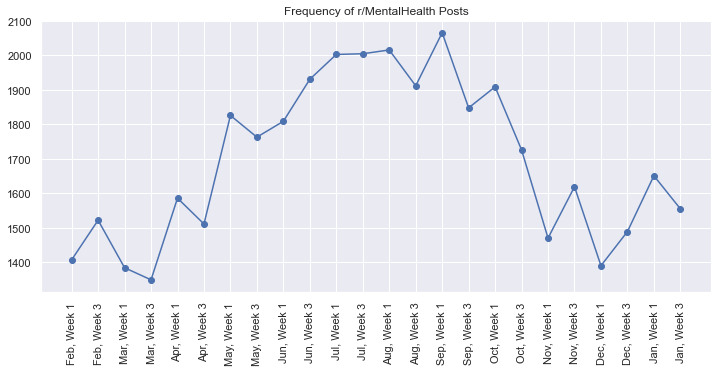

In [3]:
plt.figure(figsize=(12, 5))
plt.title('Frequency of r/MentalHealth Posts')
plt.xticks(rotation=90)
plt.plot([f'{month}, Week {i}' for month in months for i in range(1, 4, 2)], freq, 'o-')

In [7]:
#more EDA using emotion data package NRCLex
#question: should i standardize each post by number of tokens and then standardize whole weeks count by number of posts?
file_names = ['Feb1', 'Feb2', 'Mar1', 'Mar2', 'Apr1', 'Apr2', 'May1', 'May2', 'Jun1', 'Jun2', 'Jul1', 'Jul2',
                 'Aug1', 'Aug2', 'Sep1', 'Sep2', 'Oct1', 'Oct2', 'Nov1', 'Nov2', 'Dec1', 'Dec2', 'Jan1', 'Jan2']
data = []

features = {'anger': 0, 'anticipation': 1, 'disgust': 2, 'fear': 3, 'joy': 4, 'sadness': 5,
            'surprise': 6, 'trust': 7, 'negative': 8, 'positive': 9}

for file_name in file_names:
    file_name = pd.read_csv(f'raw_data/{file_name}.csv')
    file_name['text'] = file_name['text'].astype(str)
    data.append(file_name)

emotion_by_month = np.zeros((len(data),10))
for i in range(0,len(data)):
    titles = data[i]['title']
    texts = data[i]['text']
    num_tokens_per_month = 0
    for j in texts:
        tokens = nltk.word_tokenize(j.lower())
        num_tokens_per_month += len(tokens)
        emotion = NRCLex(j.lower())
        emotion_dict = emotion.raw_emotion_scores
        for key in emotion_dict:
            col = features[key]
            count = emotion_dict[key]
            emotion_by_month[i,col] += count
    for k in titles:
        tokens = nltk.word_tokenize(k.lower())
        num_tokens_per_month += len(tokens)
        emotion = NRCLex(k.lower())
        emotion_dict = emotion.raw_emotion_scores
        for key in emotion_dict:
            col = features[key]
            count = emotion_dict[key]
            emotion_by_month[i,col] += count
        
    #normalize frequency of each emotion (over the 1 week period) by number of tokens (over the 1 week period)
    emotion_by_month[i,:] = (emotion_by_month[i,:]/num_tokens_per_month)*100
            
df = pd.DataFrame(emotion_by_month, columns = ['anger','anticipation','disgust','fear','joy','sadness','surprise',
                                              'trust','negative','positive'], index = file_names)
print(df)


         anger  anticipation   disgust      fear       joy   sadness  \
Feb1  1.677359      1.345868  1.073326  1.743007  1.211511  2.086172   
Feb2  1.605693      1.995606  1.106331  2.068485  1.387847  2.183459   
Mar1  1.528554      1.715437  0.958002  1.522432  1.092133  1.613353   
Mar2  1.628286      1.899964  1.148608  2.091597  1.339348  2.213599   
Apr1  1.955578      1.054495  1.439245  2.831398  1.247137  2.873300   
Apr2  1.307096      2.294359  0.942123  3.165998  1.128955  2.535260   
May1  2.086812      1.845909  1.133658  2.792262  1.331229  3.055900   
May2  2.158587      2.393983  1.791536  2.212896  2.563133  2.298984   
Jun1  1.694757      2.192595  1.102333  2.574148  1.516740  2.398729   
Jun2  1.752587      2.000543  1.215759  2.222257  1.389216  2.317881   
Jul1  1.079261      1.923681  0.752374  1.409348  1.220683  1.797498   
Jul2  1.101855      1.844456  1.422302  1.702493  0.748777  2.042763   
Aug1  1.481963      1.370816  1.131849  1.478090  0.950814  1.58

array([[<AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>]], dtype=object)

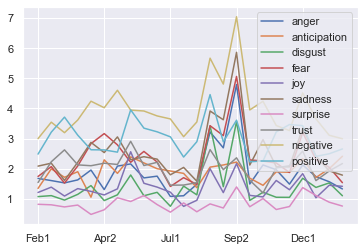

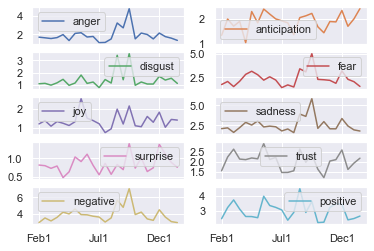

In [11]:
df.plot(kind="line")
df.plot(kind="line", subplots=True, layout=(5,2))

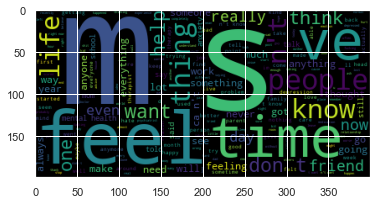

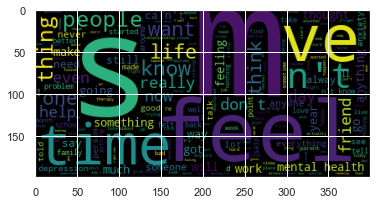

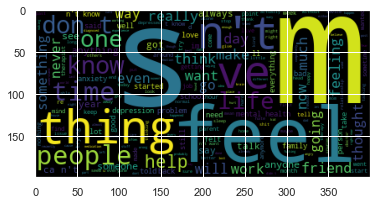

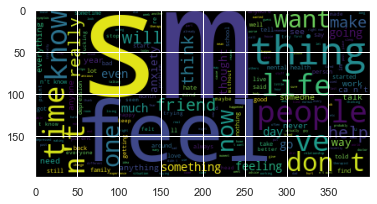

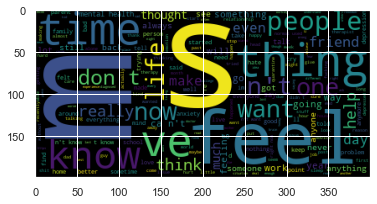

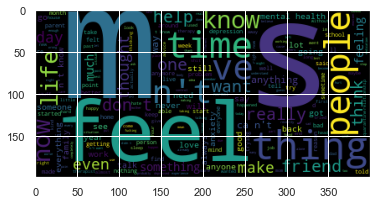

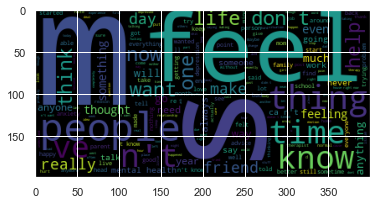

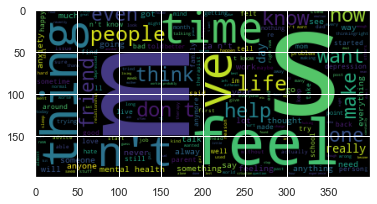

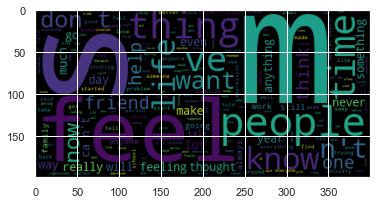

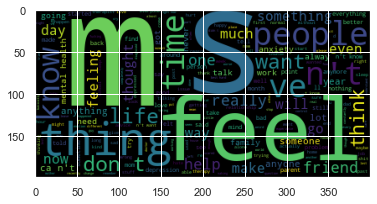

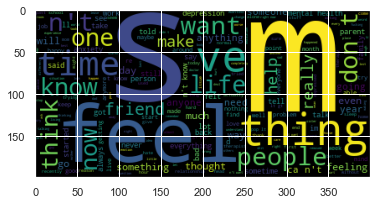

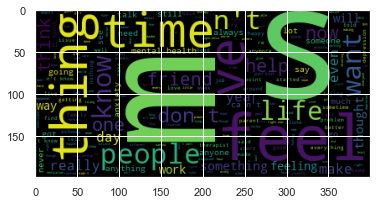

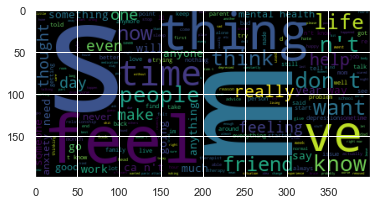

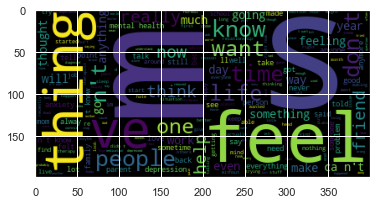

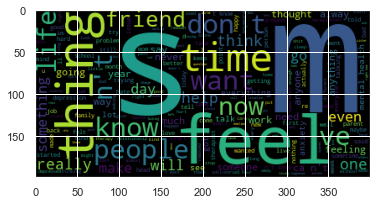

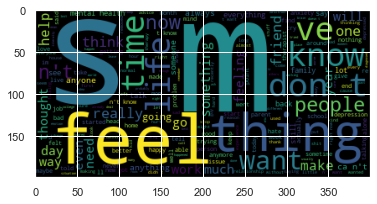

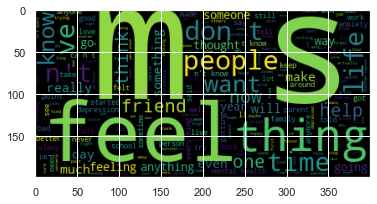

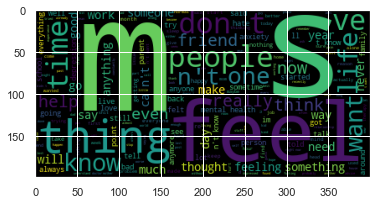

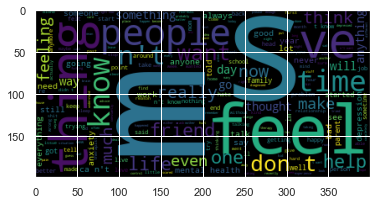

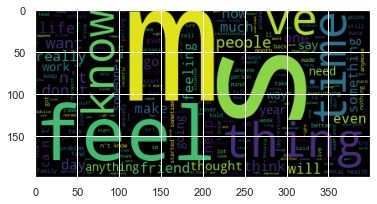

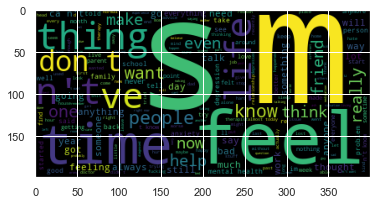

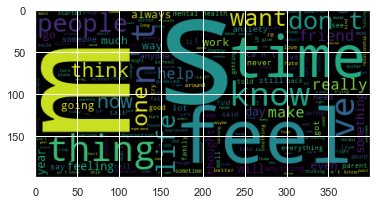

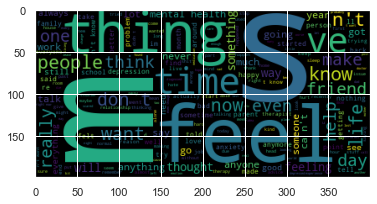

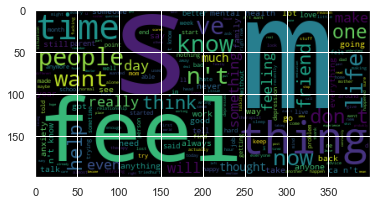

In [20]:
#generating word clouds for each of the weeks
for i in range(0,24):
    titles = data[i]['title']
    texts = data[i]['text']
    list_of_words = ''
    for j in titles:
        tokens = nltk.word_tokenize(j.lower())
        list_of_words += " ".join(tokens)+" "
    for k in texts:
        tokens = nltk.word_tokenize(k.lower())
        list_of_words += " ".join(tokens)+" "
    wc = WordCloud().generate(list_of_words)   
    plt.imshow(wc)
    plt.show()